In [1]:
# import table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import itertools as it
import json
%matplotlib inline

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.discovery.inductive.variants.im_f import algorithm as im_f_algo
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

from dpv.util.converter import param_transform, downscale, merge
from dpv.variant_transformer import private_transform, public_transform
from dpv.variant_query import variant_query
from dpv.optimizer import release_optimizer
from dpv.data_utility import emd_utility, log_diff

In [2]:
# import xes event log (sepsis example)
log = importer.apply('sepsis.xes')

# process model from xes log
net1, im1, fm1 = im_f_algo.apply(log, parameters=None)

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 1259.22it/s]


In [4]:
# compute summary statistics for single release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # convert to p and k
        p, k = param_transform(eps, d)
        
        for i in range(10):

            # privatize variants            
            traces_orig, traces_priv = private_transform(log, p, k)

            # save results
            fp = open(f"TraVaS-sqvr/variants_single_{eps}_{d}_{i}.json", "w")
            json.dump(traces_priv, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001
[+] eps: 0.001 delta: 0.5
[+] eps: 0.001 delta: 0.1
[+] eps: 0.001 delta: 0.05
[+] eps: 0.001 delta: 0.01
[+] eps: 0.001 delta: 0.001


In [4]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_single = np.zeros((len(eps_list), len(del_list)))
cost_single = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'TraVaS-sqvr/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_single[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_single[m][n] = np.mean([x for x in tmp_cost if x != 10500])
        print(f'eps: {eps}, delta: {d}, util: {util_single[m][n]}, cost: {cost_single[m][n]}')
        
# save metrics
np.savetxt('TraVaS-sqvr/util_sqvr.txt', util_single)
np.savetxt('TraVaS-sqvr/cost_sqvr.txt', cost_single)

eps: 2, delta: 0.5, util: 0.7705045124850839, cost: 120147.2
eps: 2, delta: 0.1, util: 0.6283703810410824, cost: 153775.6
eps: 2, delta: 0.05, util: 0.6220087144029827, cost: 155873.8
eps: 2, delta: 0.01, util: 0.551471865005982, cost: 165242.3
eps: 2, delta: 0.001, util: 0.5159100836505821, cost: 170808.9
eps: 1, delta: 0.5, util: 0.8402011637687815, cost: 90294.2
eps: 1, delta: 0.1, util: 0.7297895919523825, cost: 129282.7
eps: 1, delta: 0.05, util: 0.6394178838572819, cost: 151418.0
eps: 1, delta: 0.01, util: 0.5662942707555823, cost: 165110.5
eps: 1, delta: 0.001, util: 0.4746081818509823, cost: 142221.8
eps: 0.1, delta: 0.5, util: 0.8890065528277834, cost: 57763.1
eps: 0.1, delta: 0.1, util: 0.7809527261515823, cost: 91099.7
eps: 0.1, delta: 0.05, util: 0.7263642021818819, cost: 110842.6
eps: 0.1, delta: 0.01, util: 0.6225523276670872, cost: 154812.0
eps: 0.1, delta: 0.001, util: 0.44108455715099826, cost: 182256.0
eps: 0.01, delta: 0.5, util: 0.8930111468383798, cost: 54484.4
eps

In [19]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_single = np.zeros((len(eps_list), len(del_list)))
fit_single = np.zeros((len(eps_list), len(del_list)))
gen_single = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_single_avg = []
        fit_single_avg = []
        gen_single_avg = []

        for i in range(10):
            
            f = open(f'TraVaS-sqvr/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            # scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(priv_log)
            net, im, fm = im_f_algo.apply(plog, parameters=None)
            prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(log, net, im, fm)
            
            prec_single_avg.append(prec)
            fit_single_avg.append(fit['log_fitness'])
            gen_single_avg.append(gen)
            
            f.close()
        
        # save results
        prec_single[m][n] = np.mean(prec_single_avg)
        fit_single[m][n] = np.mean(fit_single_avg)
        gen_single[m][n] = np.mean(gen_single_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_single[m][n]}, fit: {fit_single[m][n]}, gen: {gen_single[m][n]}')

# save metrics
np.savetxt('TraVaS-sqvr/prec_sqvr.txt', prec_single)
np.savetxt('TraVaS-sqvr/fit_sqvr.txt', fit_single)
np.savetxt('TraVaS-sqvr/gen_sqvr.txt', gen_single)

replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 411.01it/s]


eps: 2, delta: 0.5, prec: 0.3976372460415476, fit: 0.9823690406854574, gen: 0.9522081063484714


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 411.08it/s]


eps: 2, delta: 0.1, prec: 0.4304513324341013, fit: 0.9732228759694243, gen: 0.9522601743438621


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 557.71it/s]


eps: 2, delta: 0.05, prec: 0.4847575439557269, fit: 0.970229268514565, gen: 0.9568656858999427


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 593.27it/s]


eps: 2, delta: 0.01, prec: 0.44894026010664057, fit: 0.9708541888355924, gen: 0.9621033811544528


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 530.53it/s]


eps: 2, delta: 0.001, prec: 0.5174119539466139, fit: 0.8933895355720841, gen: 0.9652485680925611


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 477.08it/s]


eps: 1, delta: 0.5, prec: 0.3798431034016093, fit: 0.9788441500728007, gen: 0.9392569019959633


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 411.72it/s]


eps: 1, delta: 0.1, prec: 0.4857338593050473, fit: 0.9689820121655897, gen: 0.946861560506472


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 492.33it/s]


eps: 1, delta: 0.05, prec: 0.45984771641972166, fit: 0.9702639407656088, gen: 0.9529344704306503


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 353.75it/s]


eps: 1, delta: 0.01, prec: 0.39257002998477813, fit: 0.9802421217217819, gen: 0.9624507116472385


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 544.71it/s]


eps: 1, delta: 0.001, prec: 0.8227574770019954, fit: 0.7465024316177943, gen: 0.9620922859632046


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 546.86it/s]


eps: 0.1, delta: 0.5, prec: 0.417247469238326, fit: 0.9701301636522082, gen: 0.9547135929659835


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 507.11it/s]


eps: 0.1, delta: 0.1, prec: 0.5193086923325785, fit: 0.9602099017007776, gen: 0.9387156015212585


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 485.02it/s]


eps: 0.1, delta: 0.05, prec: 0.5291174573502668, fit: 0.9518826307609555, gen: 0.9461361336624977


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 506.16it/s]


eps: 0.1, delta: 0.01, prec: 0.5482490751029114, fit: 0.9447182878030965, gen: 0.9604899681835471


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 588.69it/s]


eps: 0.1, delta: 0.001, prec: 0.8459264371625139, fit: 0.7740397729086739, gen: 0.9657096927088478


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 519.43it/s]


eps: 0.01, delta: 0.5, prec: 0.4538248757768941, fit: 0.9713740085545025, gen: 0.9497575718288014


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 469.25it/s]


eps: 0.01, delta: 0.1, prec: 0.4446108375243897, fit: 0.9655407141586807, gen: 0.9399632389005299


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 386.49it/s]


eps: 0.01, delta: 0.05, prec: 0.4645418809291263, fit: 0.963258874018781, gen: 0.9538904616613735


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 386.24it/s]


eps: 0.01, delta: 0.01, prec: 0.5253959939509367, fit: 0.957003441539763, gen: 0.9550105790143615


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 302.92it/s]


eps: 0.01, delta: 0.001, prec: 0.8348117603137638, fit: 0.8000821127868628, gen: 0.9612934465374768


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:02<00:00, 373.21it/s]


eps: 0.001, delta: 0.5, prec: 0.43829946481650317, fit: 0.9724582531875801, gen: 0.9472783348328238


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 430.46it/s]


eps: 0.001, delta: 0.1, prec: 0.5119191465932349, fit: 0.9594369967151797, gen: 0.9425978005998383


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 427.41it/s]


eps: 0.001, delta: 0.05, prec: 0.554884113733414, fit: 0.94654532015175, gen: 0.9500121926176502


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:03<00:00, 254.24it/s]


eps: 0.001, delta: 0.01, prec: 0.5140872057818443, fit: 0.9574661262345263, gen: 0.9580979038101191


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 754.25it/s]

eps: 0.001, delta: 0.001, prec: 0.8500044115761142, fit: 0.7711715102886963, gen: 0.9648983084952506


In [134]:
# compute summary statistics for PINQ queries

# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
pruning = [[16, 19, 20, 20, 20],[25, 36, 37, 38, 39],[63, 185, 250, 335, 355],[73, 325, 600, 1680, 3200]]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")
        
        for i in range(10):
            
            # privatize variant frequencies
            l = 0
            while l < 450 or l > 900:
                query_vars = variant_query(log, eps/19, cutoff=19, prune=pruning[m][n], delta=d/19)
                l = len(query_vars)
                
            # save results
            fp = open(f"benchmark/variants_benchmark_{eps}_{d}_{i}.json", "w")
            json.dump(query_vars, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001


In [5]:
# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_bench = np.zeros((len(eps_list), len(del_list)))
cost_bench = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_bench[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_bench[m][n] = np.mean([x for x in tmp_cost if x != 10500])
        print(f'eps: {eps}, delta: {d}, util: {util_bench[m][n]}, cost: {cost_bench[m][n]}')
        
# save metrics
np.savetxt('benchmark/util_bench.txt', util_bench)
np.savetxt('benchmark/cost_bench.txt', cost_bench)

eps: 2, delta: 0.5, util: 0.8025356736220812, cost: 2474054.2
eps: 2, delta: 0.1, util: 0.793030603259282, cost: 2897000.5
eps: 2, delta: 0.05, util: 0.7780020591652823, cost: 2762819.6
eps: 2, delta: 0.01, util: 0.7932739382896824, cost: 3048850.4
eps: 2, delta: 0.001, util: 0.7778873074781815, cost: 2782979.1
eps: 1, delta: 0.5, util: 0.8628823523160811, cost: 5510138.8
eps: 1, delta: 0.1, util: 0.7714003620736819, cost: 5447266.6
eps: 1, delta: 0.05, util: 0.7674910114039841, cost: 5952372.8
eps: 1, delta: 0.01, util: 0.8031417071823823, cost: 6912318.4
eps: 1, delta: 0.001, util: 0.769660038981582, cost: 6155031.6
eps: 0.1, delta: 0.5, util: 0.7778932546269824, cost: 11356759.5
eps: 0.1, delta: 0.1, util: 0.7749865902478823, cost: 35673701.5
eps: 0.1, delta: 0.05, util: 0.765485244432382, cost: 47514188.8
eps: 0.1, delta: 0.01, util: 0.7023465794546822, cost: 56491309.6
eps: 0.1, delta: 0.001, util: 0.7602240308316823, cost: 69021863.6
eps: 0.01, delta: 0.5, util: 0.759476988207882

In [3]:
# init arrays
eps_list = [0.1, 0.01] # [2, 1, 0.1, 0.01]
del_list = [0.01, 0.001] # [0.5, 0.1, 0.05, 0.01, 0.001]
prec_bench = np.zeros((len(eps_list), len(del_list)))
fit_bench = np.zeros((len(eps_list), len(del_list)))
gen_bench = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_bench_avg = []
        fit_bench_avg = []
        gen_bench_avg = []

        for i in range(10):
            
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            # scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(priv_log)
            net, im, fm = im_f_algo.apply(plog, parameters=None)
            prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(log, net, im, fm)
            
            prec_bench_avg.append(prec)
            fit_bench_avg.append(fit['log_fitness'])
            gen_bench_avg.append(gen)
            
            f.close()
        
        # save results
        prec_bench[m][n] = np.mean(prec_bench_avg)
        fit_bench[m][n] = np.mean(fit_bench_avg)
        gen_bench[m][n] = np.mean(gen_bench_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_bench[m][n]}, fit: {fit_bench[m][n]}, gen: {gen_bench[m][n]}')

# save metrics
# np.savetxt('benchmark/prec_bench.txt', prec_bench)
# np.savetxt('benchmark/fit_bench.txt', fit_bench)
# np.savetxt('benchmark/gen_bench.txt', gen_bench)

replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 585.05it/s]


eps: 0.1, delta: 0.01, prec: 0.18060395243871968, fit: 0.9983727833087096, gen: 0.8752606031505208


replaying log with TBR, completed variants :: 100%|██████████| 846/846 [00:01<00:00, 588.42it/s]


eps: 0.1, delta: 0.001, prec: 0.18721615476448367, fit: 0.9873792120886877, gen: 0.8594742025755456


In [3]:
# compute summary statistics for multi release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_multi = np.zeros((len(eps_list), len(del_list)))
cost_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # privatize variants
        util_multi[m][n], cost_multi[m][n], _, _, _, data = release_optimizer(log, eps, d, domain=[2,10], clean=[1.0, 10500], data=True, debug=False)
        print(f"[-] Avg Util: {util_multi[m][n]}")
        print(f"[-] Avg Cost: {cost_multi[m][n]}")
        
        # save logs
        for i, ret in enumerate(data):
            fp = open(f"variants_multi_{eps}_{d}_{i}.json", "w")
            json.dump(ret, fp)
            fp.close()
        
# save metrics
np.savetxt('util_multi.txt',util_multi)
np.savetxt('cost_multi.txt',cost_multi)

[+] eps: 2 delta: 0.5
[-] Avg Util: 0.9211099510150799
[-] Avg Cost: 29278.6
[+] eps: 2 delta: 0.1
[-] Avg Util: 0.8004159563608828
[-] Avg Cost: 39896.4
[+] eps: 2 delta: 0.05
[-] Avg Util: 0.7249507914268822
[-] Avg Cost: 106594.5
[+] eps: 2 delta: 0.01
[-] Avg Util: 0.60759075163177
[-] Avg Cost: 162086.1
[+] eps: 2 delta: 0.001
[-] Avg Util: 0.4903639386707823
[-] Avg Cost: 175627.6
[+] eps: 1 delta: 0.5
[-] Avg Util: 0.9218862203914837
[-] Avg Cost: 50709.2
[+] eps: 1 delta: 0.1
[-] Avg Util: 0.8012785936794831
[-] Avg Cost: 31979.8
[+] eps: 1 delta: 0.05
[-] Avg Util: 0.7552527570817822
[-] Avg Cost: 39303.5
[+] eps: 1 delta: 0.01
[-] Avg Util: 0.6302101337391948
[-] Avg Cost: 140792.1
[+] eps: 1 delta: 0.001
[-] Avg Util: 0.4627427012425768
[-] Avg Cost: 185637.14285714287
[+] eps: 0.1 delta: 0.5
[-] Avg Util: 0.9129425665741826
[-] Avg Cost: 20472.0
[+] eps: 0.1 delta: 0.1
[-] Avg Util: 0.8053255492966829
[-] Avg Cost: 15034.4
[+] eps: 0.1 delta: 0.05
[-] Avg Util: 0.7602856119

TypeError: Object of type ndarray is not JSON serializable

In [17]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_multi = np.zeros((len(eps_list), len(del_list)))
fit_multi = np.zeros((len(eps_list), len(del_list)))
gen_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_multi_avg = []
        fit_multi_avg = []
        gen_multi_avg = []

        for i in range(10):
            
            f = open(f'multi/variants_multi_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_multi_avg.append(prec)
            fit_multi_avg.append(fit['log_fitness'])
            gen_multi_avg.append(gen)
            
            f.close()
        
        # save results
        prec_multi[m][n] = np.mean(prec_multi_avg)
        fit_multi[m][n] = np.mean(fit_multi_avg)
        gen_multi[m][n] = np.mean(gen_multi_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_multi[m][n]}, fit: {fit_multi[m][n]}, gen: {gen_multi[m][n]}')

# save metrics
np.savetxt('multi/prec_multi.txt', prec_multi)
np.savetxt('multi/fit_multi.txt', fit_multi)
np.savetxt('multi/gen_multi.txt', gen_multi)

replaying log with TBR, completed variants ::   0%|          | 0/2450 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2807 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2659 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2314 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2741 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2640 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2729 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2983 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.4605955153358143, fit: 0.9504432621163448, gen: 0.9404462546719043


replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/748 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/741 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/766 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1400 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/656 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/856 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/691 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/607 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.38035474407805603, fit: 0.9491830289522936, gen: 0.8740050723837596


replaying log with TBR, completed variants ::   0%|          | 0/274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/313 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/270 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/355 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/367 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/430 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/446 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/574 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/326 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.33929946572958686, fit: 0.9417974935663276, gen: 0.8136367253156076


replaying log with TBR, completed variants ::   0%|          | 0/116 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.28037650354273147, fit: 0.9164968234111177, gen: 0.6192179463087677


replaying log with TBR, completed variants ::   0%|          | 0/29 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/107 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.24818376451885457, fit: 0.8449230248789364, gen: 0.38603160192403624


replaying log with TBR, completed variants ::   0%|          | 0/2750 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2844 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/379 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/379 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2539 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2856 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2809 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2602 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2745 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2954 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/370 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/370 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2312 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2568 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.4537640909124091, fit: 0.953358462149643, gen: 0.9380472142531732


replaying log with TBR, completed variants ::   0%|          | 0/889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/637 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/737 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/695 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/733 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/721 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/819 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1000 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/895 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.3830793949915954, fit: 0.9520801587622897, gen: 0.8728019677456587


replaying log with TBR, completed variants ::   0%|          | 0/654 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/301 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/396 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/328 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/581 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/476 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/344 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/437 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.3444666607322907, fit: 0.9528284806507156, gen: 0.8196198582999425


replaying log with TBR, completed variants ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/69 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/71 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/208 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.26726060333877977, fit: 0.9357427960203181, gen: 0.6068492647309801


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/35 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.15550044669609145, fit: 0.9344807124669554, gen: 0.13389925738272473


replaying log with TBR, completed variants ::   0%|          | 0/2486 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/329 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/329 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2412 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2508 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/319 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/319 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2488 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/327 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/327 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2271 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2391 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2437 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2603 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/341 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/341 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.4477796863858942, fit: 0.9514081375845518, gen: 0.934352633192912


replaying log with TBR, completed variants ::   0%|          | 0/921 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/756 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/918 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/625 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/786 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/700 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/840 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/984 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.38301283898561544, fit: 0.9547354012765238, gen: 0.873487453202857


replaying log with TBR, completed variants ::   0%|          | 0/496 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/448 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/397 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/422 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/325 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/60 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/60 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.3393087147364547, fit: 0.9527683498526495, gen: 0.8219001307521265


replaying log with TBR, completed variants ::   0%|          | 0/106 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/83 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/183 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.2607390505204693, fit: 0.9554914914341481, gen: 0.6166032136712822


replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.207449987831034, fit: 0.9653828876759952, gen: 0.2538745227821253


replaying log with TBR, completed variants ::   0%|          | 0/2777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2370 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/358 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/358 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2839 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2585 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/335 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/335 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2689 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2516 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.45303389067400596, fit: 0.9532966706057231, gen: 0.9358760143618386


replaying log with TBR, completed variants ::   0%|          | 0/732 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/675 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/704 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/750 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/927 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/787 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/800 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.37791606189370347, fit: 0.9570705799186661, gen: 0.8695046489582665


replaying log with TBR, completed variants ::   0%|          | 0/538 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/641 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/440 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/632 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/536 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.3515770232277442, fit: 0.9557581158277163, gen: 0.8329614445233198


replaying log with TBR, completed variants ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/78 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/160 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.2686714658197714, fit: 0.9477683753297708, gen: 0.6145901995380948


replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.19547913320255864, fit: 0.94795882899674, gen: 0.11286205137798995


replaying log with TBR, completed variants ::   0%|          | 0/2374 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/324 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/324 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2936 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/350 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/350 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/325 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/325 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2538 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/354 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/354 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2442 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2172 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2075 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.4505182867104923, fit: 0.9528958162797767, gen: 0.9350834926887781


replaying log with TBR, completed variants ::   0%|          | 0/879 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/105 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/105 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/872 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/725 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/710 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/808 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/818 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/835 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/999 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/902 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.37812853902020216, fit: 0.9544111620222543, gen: 0.8751677606649906


replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/434 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/556 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/464 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/376 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/393 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/401 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/497 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.3376191574560537, fit: 0.9579215889458876, gen: 0.8209977972350808


replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/164 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.2547026240248423, fit: 0.9528305055738061, gen: 0.5869476881479014


replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.19273513622648814, fit: 0.9715234334117129, gen: 0.15063983428183841


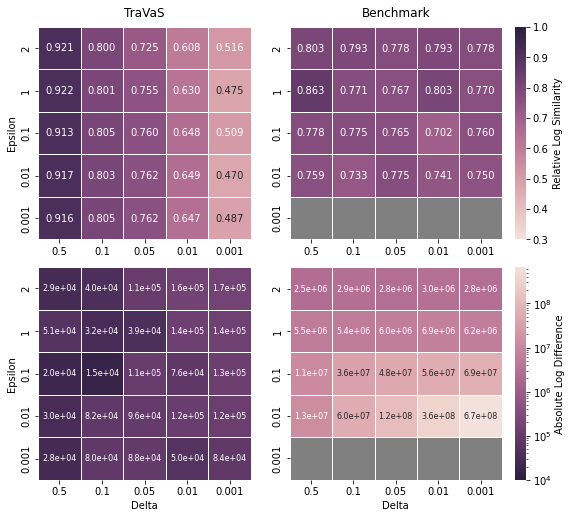

In [2]:
# load final data
util_single = np.loadtxt('TraVaS-sqvr/util_sqvr.txt')
util_multi = np.loadtxt('TraVaS-optimizer/util_opt.txt')
util_bench = np.loadtxt('benchmark/util_bench.txt')

cost_single = np.loadtxt('TraVaS-sqvr/cost_single.txt')
cost_multi = np.loadtxt('multi/cost_multi.txt')
cost_bench = np.loadtxt('benchmark/cost_bench.txt')

util_best = np.maximum(util_single, util_multi)
util_bench = np.vstack([util_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
cost_best = np.minimum(cost_single, cost_multi)
cost_bench = np.vstack([cost_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_best, ax=ax[0,0], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(util_bench, ax=ax[0,1], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Relative Log Similarity'})
ax[1,0] = sns.heatmap(cost_best, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_bench, ax=ax[1,1], cmap=cmap_r, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Absolute Log Difference'}, annot_kws={"fontsize":8})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_1.pdf")

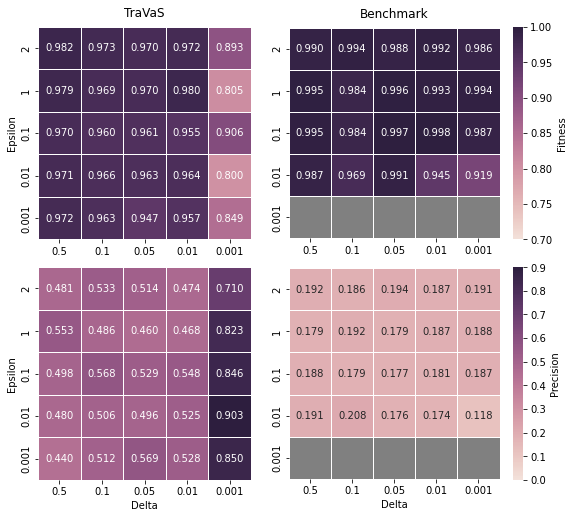

In [4]:
# load final data
prec_single = np.loadtxt('TraVaS-sqvr/prec_sqvr.txt')
prec_multi = np.loadtxt('TraVaS-optimizer/prec_opt.txt')
prec_bench = np.loadtxt('benchmark/prec_bench.txt')
prec_bench = np.vstack([prec_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
prec_best = np.maximum(prec_single, prec_multi)

fit_single = np.loadtxt('TraVaS-sqvr/fit_sqvr.txt')
fit_multi = np.loadtxt('TraVaS-optimizer/fit_opt.txt')
fit_bench = np.loadtxt('benchmark/fit_bench.txt')
fit_bench = np.vstack([fit_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
fit_best = np.maximum(fit_single, fit_multi)

gen_single = np.loadtxt('TraVaS-sqvr/gen_sqvr.txt')
gen_multi = np.loadtxt('TraVaS-optimizer/gen_opt.txt')
gen_bench = np.loadtxt('benchmark/gen_bench.txt')
gen_bench = np.vstack([gen_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
gen_best = np.maximum(gen_single, gen_multi)

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_best, ax=ax[0,0], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_bench, ax=ax[0,1], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(fit_bench), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_best, ax=ax[1,0], cmap=cmap, square=True, vmin=0, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_bench, ax=ax[1,1], cmap=cmap, vmin=0, vmax=0.9, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Precision'})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_2.pdf")

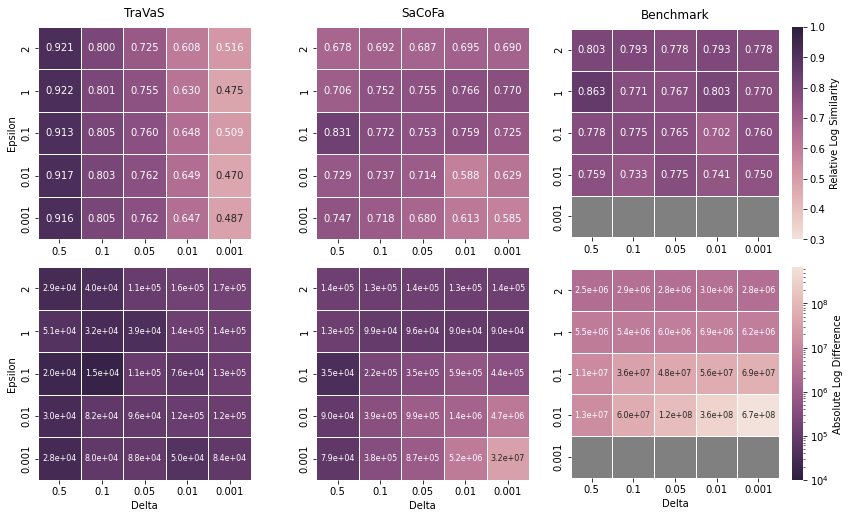

In [19]:
# load final data
util_single = np.loadtxt('single/util_single.txt')
util_multi = np.loadtxt('multi/util_multi.txt')
util_sacofa = np.loadtxt('sacofa/util_sacofa.txt')
util_bench = np.loadtxt('benchmark/util_bench.txt')

cost_single = np.loadtxt('single/cost_single.txt')
cost_multi = np.loadtxt('multi/cost_multi.txt')
cost_sacofa = np.loadtxt('sacofa/cost_sacofa.txt')
cost_bench = np.loadtxt('benchmark/cost_bench.txt')

util_best = np.maximum(util_single, util_multi)
util_bench = np.vstack([util_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
cost_best = np.minimum(cost_single, cost_multi)
cost_bench = np.vstack([cost_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])

# create plots
f, ax = plt.subplots(2, 3, figsize=(12.2, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_best, ax=ax[0,0], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(util_sacofa, ax=ax[0,1], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=False, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,2] = sns.heatmap(util_bench, ax=ax[0,2], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Relative Log Similarity'})
ax[1,0] = sns.heatmap(cost_best, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_sacofa, ax=ax[1,1], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,2] = sns.heatmap(cost_bench, ax=ax[1,2], cmap=cmap_r, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Absolute Log Difference'}, annot_kws={"fontsize":8})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('SaCoFa', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_1_extended.pdf")

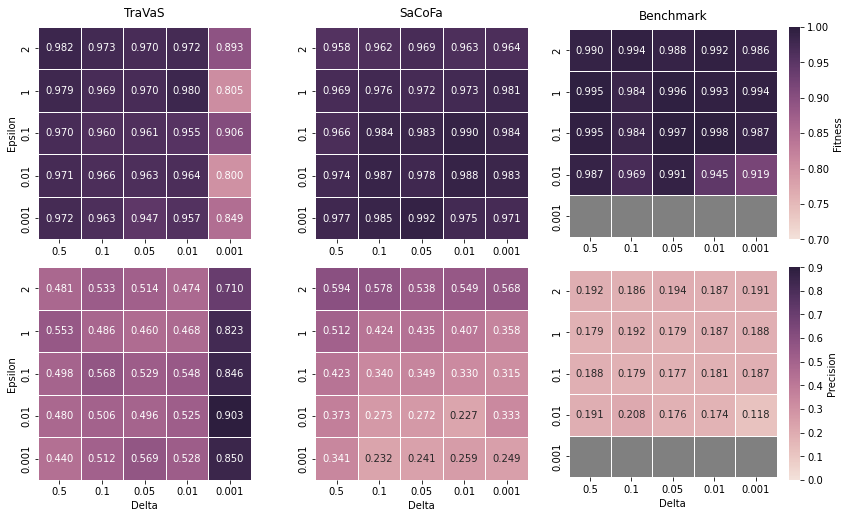

In [4]:
# load final data
prec_single = np.loadtxt('TraVaS-sqvr/prec_sqvr.txt')
prec_multi = np.loadtxt('TraVaS-optimizer/prec_opt.txt')
prec_sacofa = np.loadtxt('sacofa/prec_sacofa.txt')
prec_bench = np.loadtxt('benchmark/prec_bench.txt')
prec_bench = np.vstack([prec_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
prec_best = np.maximum(prec_single, prec_multi)

fit_single = np.loadtxt('TraVaS-sqvr/fit_sqvr.txt')
fit_multi = np.loadtxt('TraVaS-optimizer/fit_opt.txt')
fit_sacofa = np.loadtxt('sacofa/fit_sacofa.txt')
fit_bench = np.loadtxt('benchmark/fit_bench.txt')
fit_bench = np.vstack([fit_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
fit_best = np.maximum(fit_single, fit_multi)

gen_single = np.loadtxt('TraVaS-sqvr/gen_sqvr.txt')
gen_multi = np.loadtxt('TraVaS-optimizer/gen_opt.txt')
gen_sacofa = np.loadtxt('sacofa/gen_sacofa.txt')
gen_bench = np.loadtxt('benchmark/gen_bench.txt')
gen_bench = np.vstack([gen_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
gen_best = np.maximum(gen_single, gen_multi)

# create plots
f, ax = plt.subplots(2, 3, figsize=(12.2, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_best, ax=ax[0,0], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_sacofa, ax=ax[0,1], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,2] = sns.heatmap(fit_bench, ax=ax[0,2], vmin=0.7, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(fit_bench), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_best, ax=ax[1,0], cmap=cmap, square=True, vmin=0, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_sacofa, ax=ax[1,1], cmap=cmap, square=True, vmin=0, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[1,2] = sns.heatmap(prec_bench, ax=ax[1,2], cmap=cmap, vmin=0, vmax=0.9, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Precision'})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('SaCoFa', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("Sepsis_2_extended.pdf")